In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from time import perf_counter
import random
import pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'GuidedBP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GIN"
DataSet_name = "MUTAG"
normalize_coeff = 100
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [6]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [7]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [8]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [9]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# **Model Designing**

In [10]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)

import GIN as gin_model
GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7,
                                mlp_output_dim=7, mlp_act_fun="ReLu", num_classes=2, dropout_rate=classifier_dropout,
                                Weight_Initializer=3)

In [11]:
GNN_Model_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [12]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [13]:
def loading_model(load_index):

    GNN_Model = gin_model.GIN_Model(num_mlp_layers=4, Bias=classifier_bias, num_slp_layers=2, mlp_input_dim=7, mlp_hid_dim=7,
                                    mlp_output_dim=7, mlp_act_fun="ReLu", num_classes=2, dropout_rate=classifier_dropout,
                                    Weight_Initializer=3)
    GuidedBP_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1) + ".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    GuidedBP_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GNN_Model, GNN_Model_optimizer, epoch

In [14]:
def visualize_losses(g_losses, epoch_history):
    g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Guided Model Loss in Epoch: " + str(epoch_history))

    ax.plot(g_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

# **Traning Configurations**

In [15]:
def train_step():
    GuidedBP_loss_batch = []
    GuidedBP_Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model_optimizer.zero_grad()
    for batched_data in train_loader:
        mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batched_data, None)
        pred = soft.argmax(dim=1)
        GuidedBP_Pred_Labels.extend(pred.detach().tolist())

        Real_Labels.extend(batched_data.y.detach().tolist())
        GuidedBP_loss = loss_calculations(soft, batched_data.y)
        GuidedBP_loss_batch.append(GuidedBP_loss)
        GuidedBP_loss.backward()
        GNN_Model_optimizer.step()


        #GuidedBP_optimizer.step()

    #############################################################



    return torch.mean(torch.tensor(GuidedBP_loss_batch)), metrics.accuracy_score(Real_Labels, GuidedBP_Pred_Labels)


In [16]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [17]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

GuidedBP_Model_training_time_per_epoch = []
GuidedBP_Model_training_Acc_per_epoch = []

def train(EPOCHS, load_index):
    GuidedBP_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        GuidedBP_model_training_loss, training_acc = train_step()
        GuidedBP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        GuidedBP_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GuidedBP_model_training_loss:.4f}')

        GuidedBP_training_loss_per_epoch.append(GuidedBP_model_training_loss)


        if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(GuidedBP_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_optimizer.state_dict(), 'loss': GuidedBP_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")


  #return model_loss





Epoch: 001, GuidedBP Model Loss: 0.6452
Epoch: 002, GuidedBP Model Loss: 0.6255
Epoch: 003, GuidedBP Model Loss: 0.5967
Epoch: 004, GuidedBP Model Loss: 0.6226
Epoch: 005, GuidedBP Model Loss: 0.6347
Epoch: 006, GuidedBP Model Loss: 0.6619
Epoch: 007, GuidedBP Model Loss: 0.6413
Epoch: 008, GuidedBP Model Loss: 0.6413
Epoch: 009, GuidedBP Model Loss: 0.6387
Epoch: 010, GuidedBP Model Loss: 0.6236
Epoch: 011, GuidedBP Model Loss: 0.6394
Epoch: 012, GuidedBP Model Loss: 0.6356
Epoch: 013, GuidedBP Model Loss: 0.6273
Epoch: 014, GuidedBP Model Loss: 0.6634
Epoch: 015, GuidedBP Model Loss: 0.6492
Epoch: 016, GuidedBP Model Loss: 0.6313
Epoch: 017, GuidedBP Model Loss: 0.6164
Epoch: 018, GuidedBP Model Loss: 0.6336
Epoch: 019, GuidedBP Model Loss: 0.6038
Epoch: 020, GuidedBP Model Loss: 0.6495
Epoch: 021, GuidedBP Model Loss: 0.6601
Epoch: 022, GuidedBP Model Loss: 0.6211
Epoch: 023, GuidedBP Model Loss: 0.6583
Epoch: 024, GuidedBP Model Loss: 0.6053
Epoch: 025, GuidedBP Model Loss: 0.6310


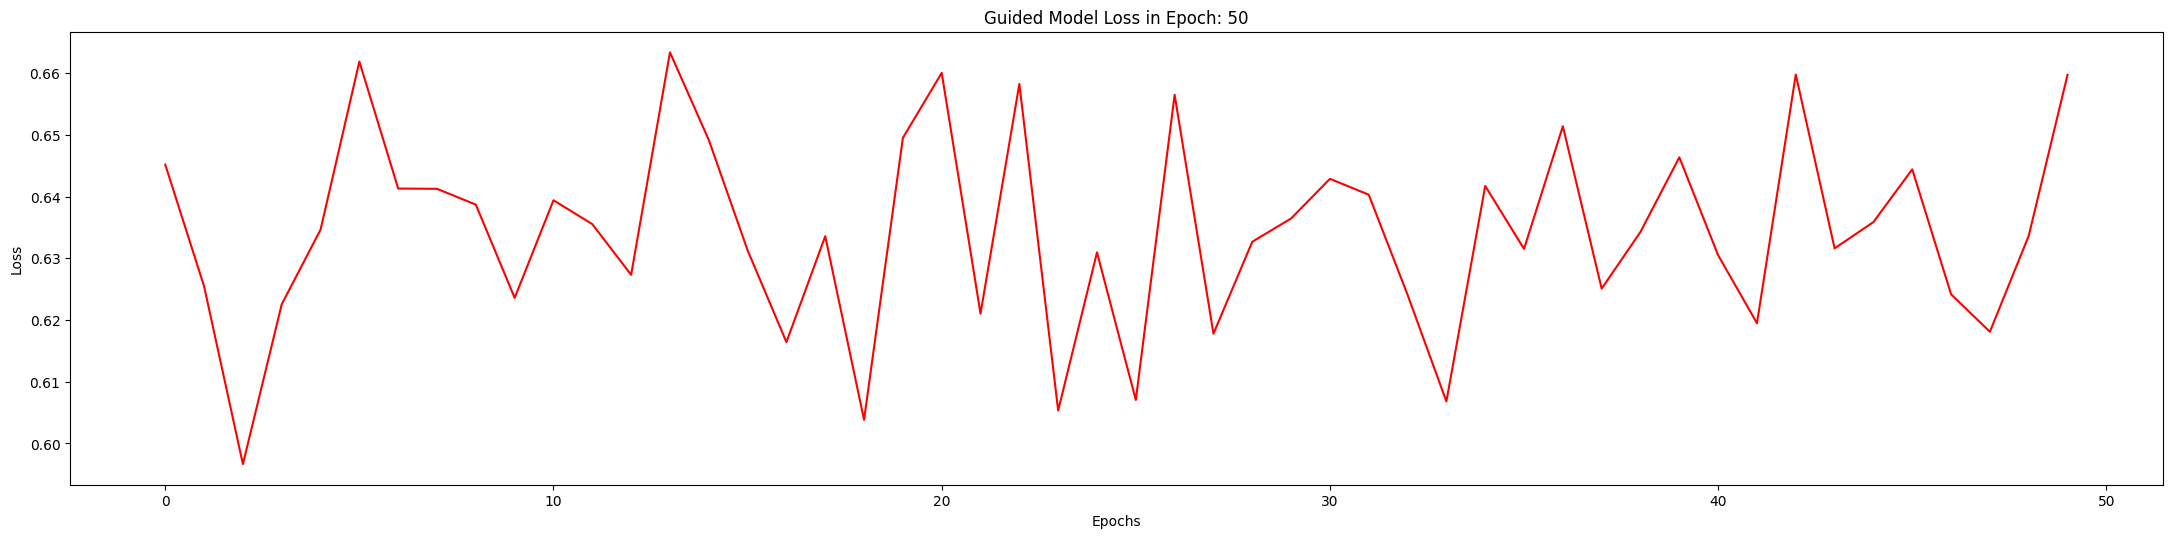

Epoch: 051, GuidedBP Model Loss: 0.6299
Epoch: 052, GuidedBP Model Loss: 0.6433
Epoch: 053, GuidedBP Model Loss: 0.6346
Epoch: 054, GuidedBP Model Loss: 0.6563
Epoch: 055, GuidedBP Model Loss: 0.6341
Epoch: 056, GuidedBP Model Loss: 0.6116
Epoch: 057, GuidedBP Model Loss: 0.6528
Epoch: 058, GuidedBP Model Loss: 0.6269
Epoch: 059, GuidedBP Model Loss: 0.6446
Epoch: 060, GuidedBP Model Loss: 0.6398
Epoch: 061, GuidedBP Model Loss: 0.6763
Epoch: 062, GuidedBP Model Loss: 0.6393
Epoch: 063, GuidedBP Model Loss: 0.6108
Epoch: 064, GuidedBP Model Loss: 0.6250
Epoch: 065, GuidedBP Model Loss: 0.6143
Epoch: 066, GuidedBP Model Loss: 0.6507
Epoch: 067, GuidedBP Model Loss: 0.6123
Epoch: 068, GuidedBP Model Loss: 0.6544
Epoch: 069, GuidedBP Model Loss: 0.6453
Epoch: 070, GuidedBP Model Loss: 0.6265
Epoch: 071, GuidedBP Model Loss: 0.6341
Epoch: 072, GuidedBP Model Loss: 0.6389
Epoch: 073, GuidedBP Model Loss: 0.6525
Epoch: 074, GuidedBP Model Loss: 0.6363
Epoch: 075, GuidedBP Model Loss: 0.6072


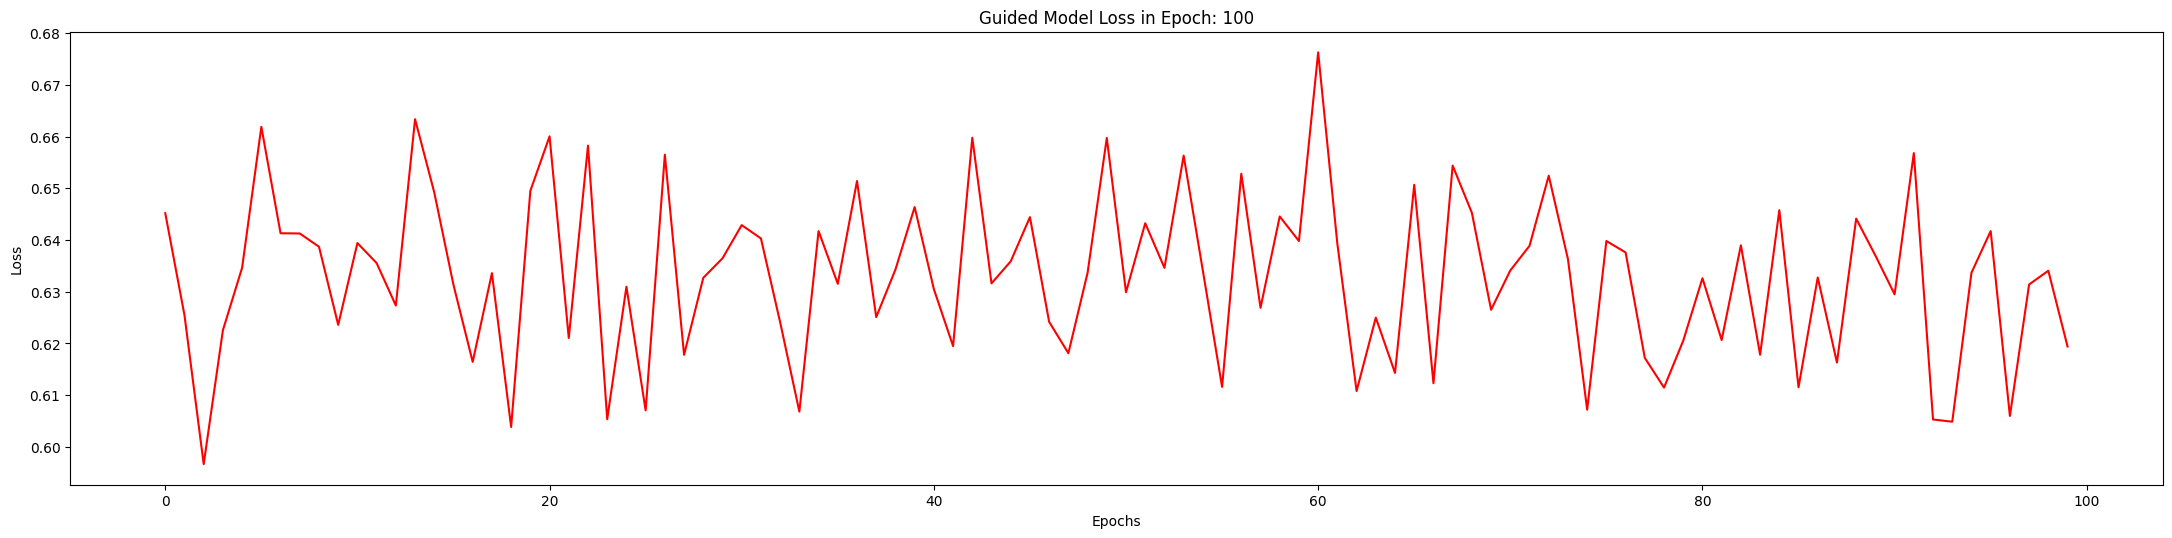

Epoch: 101, GuidedBP Model Loss: 0.6458
Epoch: 102, GuidedBP Model Loss: 0.6230
Epoch: 103, GuidedBP Model Loss: 0.6329
Epoch: 104, GuidedBP Model Loss: 0.6302
Epoch: 105, GuidedBP Model Loss: 0.6300
Epoch: 106, GuidedBP Model Loss: 0.6257
Epoch: 107, GuidedBP Model Loss: 0.6015
Epoch: 108, GuidedBP Model Loss: 0.6360
Epoch: 109, GuidedBP Model Loss: 0.6295
Epoch: 110, GuidedBP Model Loss: 0.6330
Epoch: 111, GuidedBP Model Loss: 0.6130
Epoch: 112, GuidedBP Model Loss: 0.6516
Epoch: 113, GuidedBP Model Loss: 0.6306
Epoch: 114, GuidedBP Model Loss: 0.6368
Epoch: 115, GuidedBP Model Loss: 0.6264
Epoch: 116, GuidedBP Model Loss: 0.6413
Epoch: 117, GuidedBP Model Loss: 0.6494
Epoch: 118, GuidedBP Model Loss: 0.6042
Epoch: 119, GuidedBP Model Loss: 0.6608
Epoch: 120, GuidedBP Model Loss: 0.6355
Epoch: 121, GuidedBP Model Loss: 0.6556
Epoch: 122, GuidedBP Model Loss: 0.6028
Epoch: 123, GuidedBP Model Loss: 0.6251
Epoch: 124, GuidedBP Model Loss: 0.6214
Epoch: 125, GuidedBP Model Loss: 0.6299


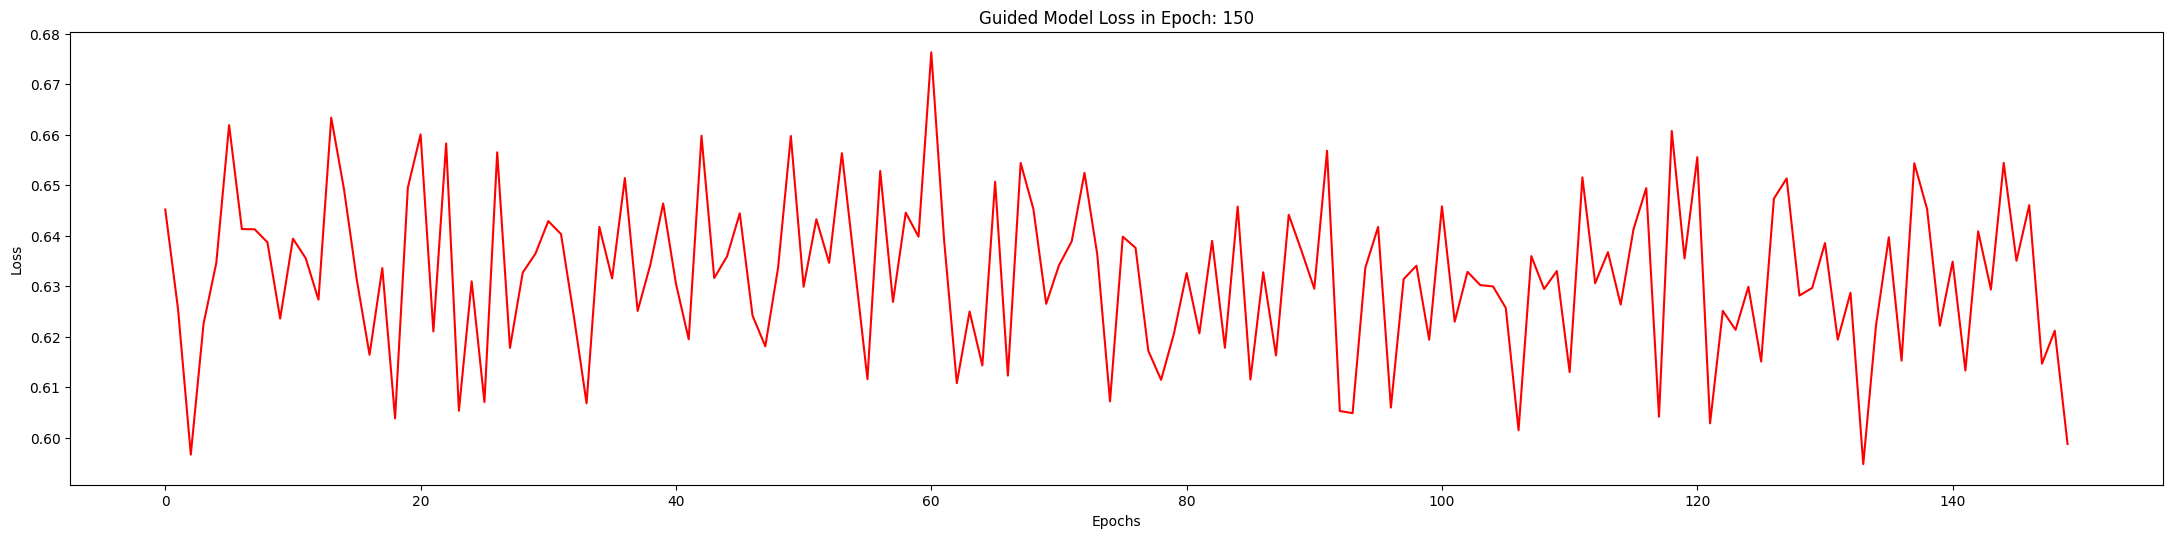

Epoch: 151, GuidedBP Model Loss: 0.6437
Epoch: 152, GuidedBP Model Loss: 0.6348
Epoch: 153, GuidedBP Model Loss: 0.6573
Epoch: 154, GuidedBP Model Loss: 0.6317
Epoch: 155, GuidedBP Model Loss: 0.6313
Epoch: 156, GuidedBP Model Loss: 0.6498
Epoch: 157, GuidedBP Model Loss: 0.6535
Epoch: 158, GuidedBP Model Loss: 0.6350
Epoch: 159, GuidedBP Model Loss: 0.6424
Epoch: 160, GuidedBP Model Loss: 0.6531
Epoch: 161, GuidedBP Model Loss: 0.6470
Epoch: 162, GuidedBP Model Loss: 0.6256
Epoch: 163, GuidedBP Model Loss: 0.6253
Epoch: 164, GuidedBP Model Loss: 0.6120
Epoch: 165, GuidedBP Model Loss: 0.6175
Epoch: 166, GuidedBP Model Loss: 0.6332
Epoch: 167, GuidedBP Model Loss: 0.6389
Epoch: 168, GuidedBP Model Loss: 0.6286
Epoch: 169, GuidedBP Model Loss: 0.6171
Epoch: 170, GuidedBP Model Loss: 0.6299
Epoch: 171, GuidedBP Model Loss: 0.6098
Epoch: 172, GuidedBP Model Loss: 0.6089
Epoch: 173, GuidedBP Model Loss: 0.6333
Epoch: 174, GuidedBP Model Loss: 0.6663
Epoch: 175, GuidedBP Model Loss: 0.6571


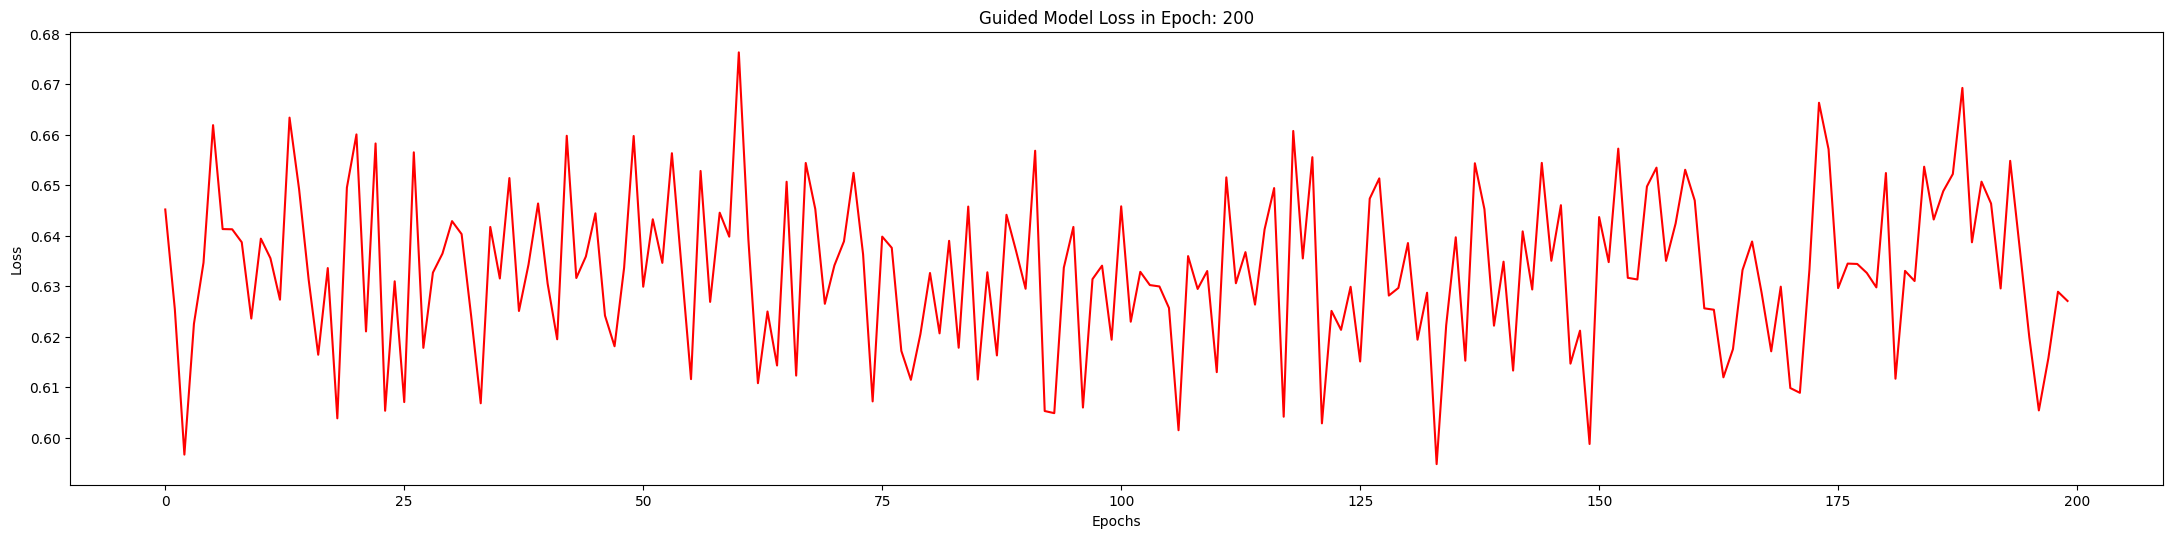

Epoch: 201, GuidedBP Model Loss: 0.6150
Epoch: 202, GuidedBP Model Loss: 0.6405
Epoch: 203, GuidedBP Model Loss: 0.6382
Epoch: 204, GuidedBP Model Loss: 0.6830
Epoch: 205, GuidedBP Model Loss: 0.6380
Epoch: 206, GuidedBP Model Loss: 0.6104
Epoch: 207, GuidedBP Model Loss: 0.6486
Epoch: 208, GuidedBP Model Loss: 0.6446
Epoch: 209, GuidedBP Model Loss: 0.6160
Epoch: 210, GuidedBP Model Loss: 0.6453
Epoch: 211, GuidedBP Model Loss: 0.6354
Epoch: 212, GuidedBP Model Loss: 0.6265
Epoch: 213, GuidedBP Model Loss: 0.6459
Epoch: 214, GuidedBP Model Loss: 0.6145
Epoch: 215, GuidedBP Model Loss: 0.6218
Epoch: 216, GuidedBP Model Loss: 0.6239
Epoch: 217, GuidedBP Model Loss: 0.6128
Epoch: 218, GuidedBP Model Loss: 0.6414
Epoch: 219, GuidedBP Model Loss: 0.6130
Epoch: 220, GuidedBP Model Loss: 0.6493
Epoch: 221, GuidedBP Model Loss: 0.6659
Epoch: 222, GuidedBP Model Loss: 0.6433
Epoch: 223, GuidedBP Model Loss: 0.6230
Epoch: 224, GuidedBP Model Loss: 0.6378
Epoch: 225, GuidedBP Model Loss: 0.6428


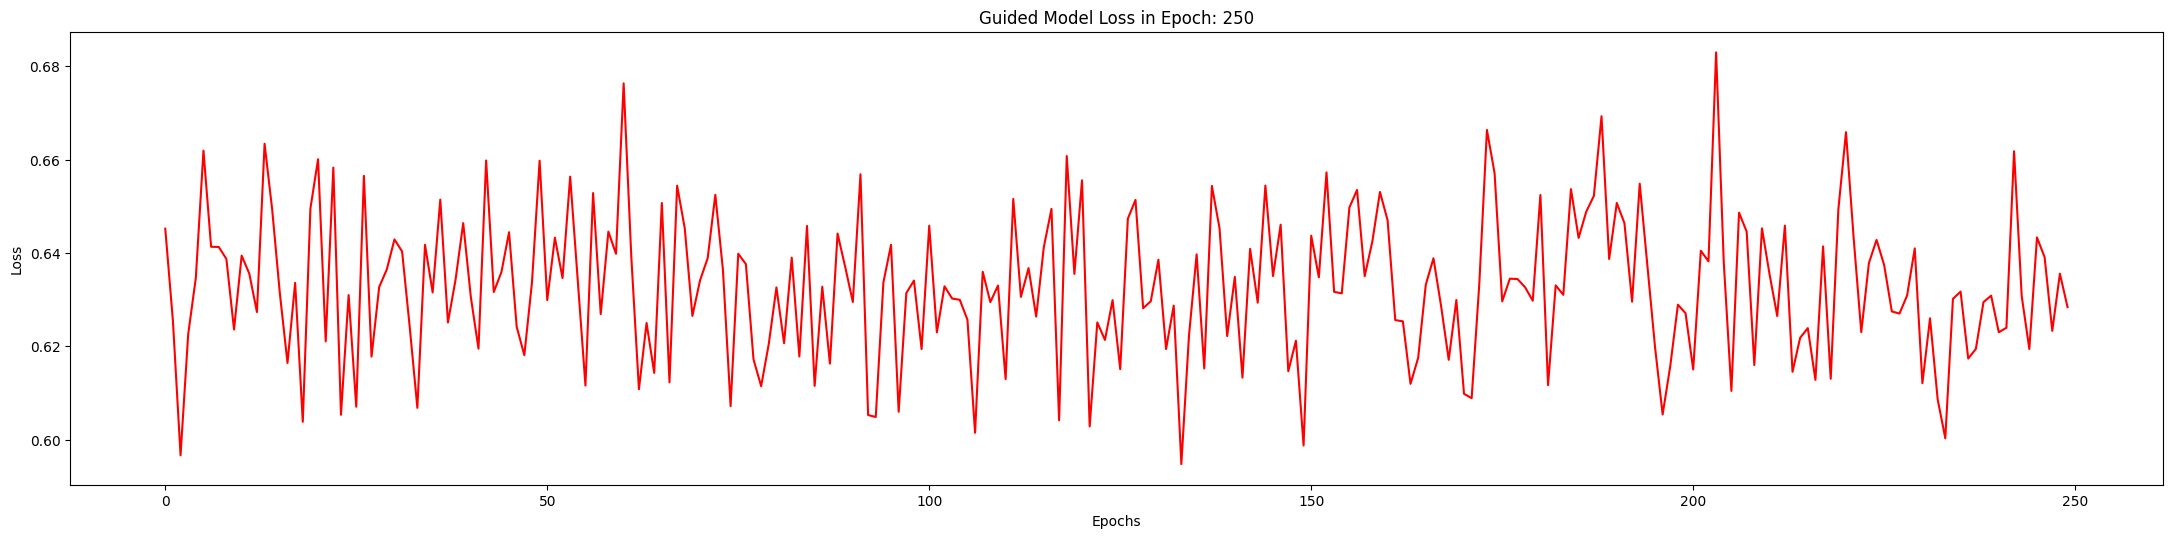

Epoch: 251, GuidedBP Model Loss: 0.6739
Epoch: 252, GuidedBP Model Loss: 0.6140
Epoch: 253, GuidedBP Model Loss: 0.6501
Epoch: 254, GuidedBP Model Loss: 0.6239
Epoch: 255, GuidedBP Model Loss: 0.6184
Epoch: 256, GuidedBP Model Loss: 0.6238
Epoch: 257, GuidedBP Model Loss: 0.6597
Epoch: 258, GuidedBP Model Loss: 0.6425
Epoch: 259, GuidedBP Model Loss: 0.6532
Epoch: 260, GuidedBP Model Loss: 0.6224
Epoch: 261, GuidedBP Model Loss: 0.6394
Epoch: 262, GuidedBP Model Loss: 0.6499
Epoch: 263, GuidedBP Model Loss: 0.6585
Epoch: 264, GuidedBP Model Loss: 0.6127
Epoch: 265, GuidedBP Model Loss: 0.6513
Epoch: 266, GuidedBP Model Loss: 0.6443
Epoch: 267, GuidedBP Model Loss: 0.6101
Epoch: 268, GuidedBP Model Loss: 0.6499
Epoch: 269, GuidedBP Model Loss: 0.6660
Epoch: 270, GuidedBP Model Loss: 0.6184
Epoch: 271, GuidedBP Model Loss: 0.6540
Epoch: 272, GuidedBP Model Loss: 0.6427
Epoch: 273, GuidedBP Model Loss: 0.6261
Epoch: 274, GuidedBP Model Loss: 0.6398
Epoch: 275, GuidedBP Model Loss: 0.6297


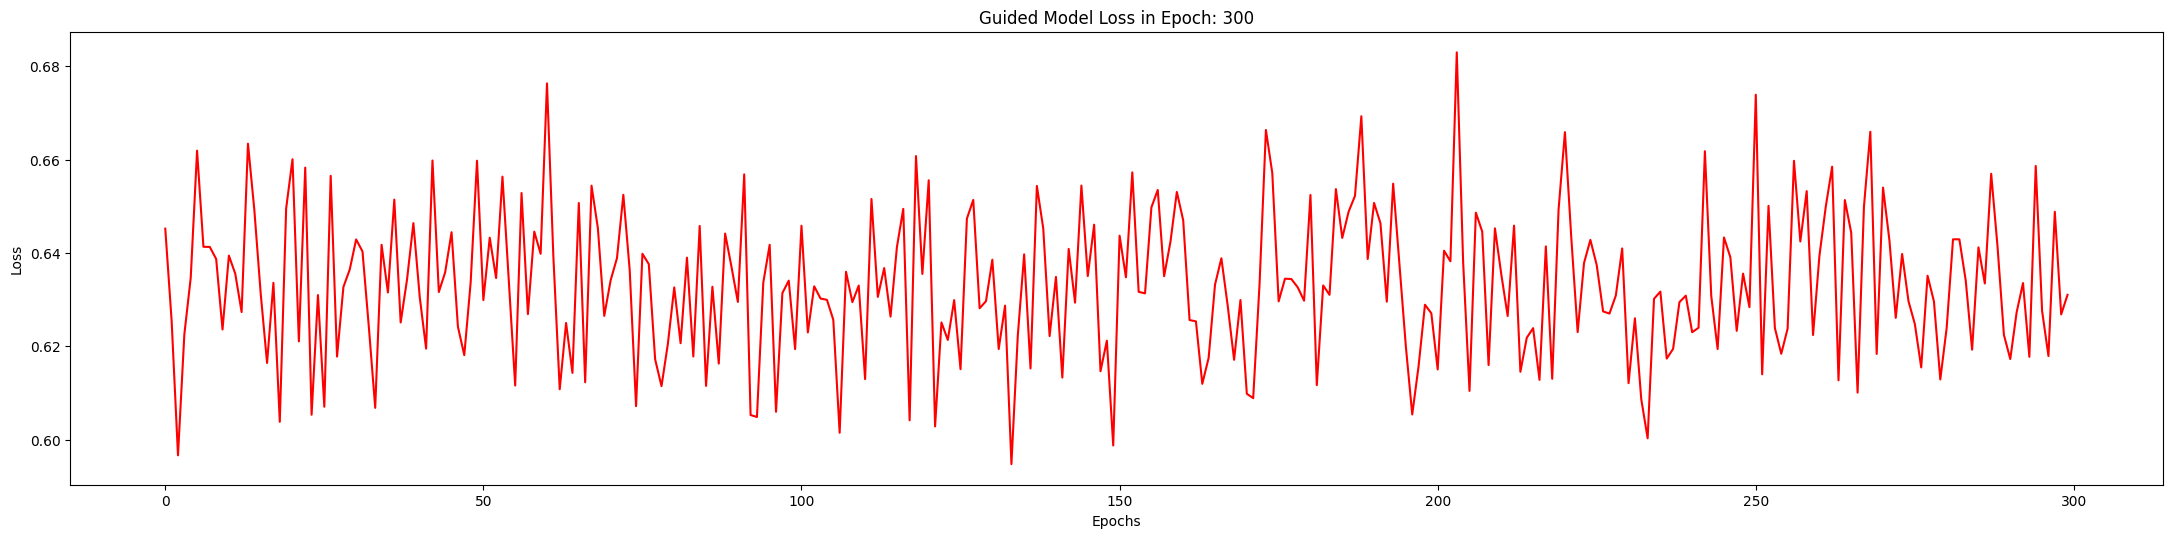

In [18]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [19]:
def GuidedBP_test(test_loader):
    predictions = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_loader:
        mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batched_data, None)
        GuidedBP_test_pred = soft.argmax(dim=1)
        predictions.extend(GuidedBP_test_pred.detach().tolist())
        correct += int((GuidedBP_test_pred == batched_data.y).sum())
    return correct / len(test_loader.dataset), predictions

In [20]:
GuidedBP_test_acc, predictions = GuidedBP_test(test_loader)
print(f'Test Accuracy: {GuidedBP_test_acc:.4f}')

Test Accuracy: 0.6316


In [21]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [22]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5 0.8157894736842105 0.631578947368421 24


## **Instance Specific Time**

In [23]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, soft = GNN_Model(batched_data, None)
        Guided_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [24]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.005330817000015031, 0.003160171999979866, 0.0022764029999962077, 0.002025122000020474, 0.001994759000012891, 0.001957276999974056, 0.0020180040000354893, 0.001983648000020821, 0.0019737750000103915, 0.001941469000030338, 0.001946092000025601, 0.0020707159999915348, 0.0019925670000020546, 0.0019376220000140165, 0.0019319329999802903, 0.001998495999998795, 0.0019589109999742504, 0.001958956000009948, 0.0019409970000197063, 0.0029080830000225433, 0.001999203000025318, 0.0019631040000263056, 0.0020381699999916236, 0.0019600300000206516, 0.001944239000010839, 0.001957511999989947, 0.0020061959999679857, 0.0019788660000017444, 0.0019362999999543717, 0.0019437860000266483, 0.00200009900004261, 0.001951356000006399, 0.0019314890000146079, 0.001955479999992349, 0.0019571359999872584, 0.0019344550000255367, 0.0019407080000064525, 0.0019887429999698725]


## **Gradients of Test Samples with respect to each class**

In [31]:
def compute_grad(model, graph, with_respect):
    mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, prediction = model(graph, None)
    if with_respect == 1 :
        loss = loss_calculations(prediction, graph.y)
        #print(loss)
    elif with_respect == 2:
        loss = loss_calculations(prediction, torch.tensor([0]))
        #print(loss)
    elif with_respect == 3:
        loss = loss_calculations(prediction, torch.tensor([1]))
        #print(loss)
    GNN_Model_optimizer.zero_grad()
    return torch.autograd.grad(loss, list(model.parameters()),allow_unused=True)

In [32]:
def remove_nones(sample_grads):
    sample_grads2 = []
    for item in sample_grads:
        Each_Graph = []
        for item2 in item:
            if item2 != None:
                Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
            else:
                Each_Graph.append(torch.tensor(0))
        sample_grads2.append(Each_Graph)
    return sample_grads2

In [33]:
def compute_sample_grads(model, test_dataset, with_respect):

    sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
    sample_grads = remove_nones(sample_grads)
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads

In [34]:
per_sample_grads_wrt_graph_label = compute_sample_grads(GNN_Model, test_dataset, 1)
per_sample_grads_wrt_class_zero = compute_sample_grads(GNN_Model, test_dataset, 2)
per_sample_grads_wrt_class_one = compute_sample_grads(GNN_Model, test_dataset, 3)

<ipython-input-32-f6e5caef69dc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


In [ ]:
a = torch.randn((2,7))
print(a)
b = torch.zeros_like(a)
print(b)
c = torch.maximum(a, b)
print(c)

tensor([[ 0.0086,  0.9609, -1.3321,  0.2983,  1.5373,  1.2004, -1.0721],
        [ 0.0091,  1.2569,  0.6611,  0.8653, -1.8195,  0.7760,  1.2147]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([[0.0086, 0.9609, 0.0000, 0.2983, 1.5373, 1.2004, 0.0000],
        [0.0091, 1.2569, 0.6611, 0.8653, 0.0000, 0.7760, 1.2147]])


In [35]:
def column_wise_addups(gradients):
    return np.sum(gradients, axis=1).tolist()

In [36]:
def compute_guided_gradients(your_model, dataset):
    per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
    per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
    per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

    indexes = [1, 3, 9, 11]
    ref = torch.zeros_like(per_sample_grads_wrt_class_zero[1])
    for i in indexes:
        ref = ref + per_sample_grads_wrt_class_zero[i]
    per_sample_grads_wrt_class_zero = torch.squeeze(ref, dim=0)

    ref = torch.zeros_like(per_sample_grads_wrt_class_one[1])
    for i in indexes:
        ref = ref + per_sample_grads_wrt_class_one[i]
    per_sample_grads_wrt_class_one = torch.squeeze(ref, dim=0)

    ref = torch.zeros_like(per_sample_grads_wrt_graph_label[1])
    for i in indexes:
        ref = ref + per_sample_grads_wrt_graph_label[i]
    per_sample_grads_wrt_graph_label = torch.squeeze(ref, dim=0)

    grads_wrt_graph_label = per_sample_grads_wrt_graph_label
    guided_grads_wrt_graph_label = torch.maximum(torch.zeros_like(grads_wrt_graph_label), grads_wrt_graph_label)
    guided_grads_wrt_graph_label = guided_grads_wrt_graph_label.detach().tolist()

    grads_wrt_class_zero = per_sample_grads_wrt_class_zero
    guided_grads_wrt_class_zero = torch.maximum(torch.zeros_like(grads_wrt_class_zero), grads_wrt_class_zero)
    guided_grads_wrt_class_zero = guided_grads_wrt_class_zero.detach().tolist()

    grads_wrt_class_one = per_sample_grads_wrt_class_one
    guided_grads_wrt_class_one = torch.maximum(torch.zeros_like(grads_wrt_class_one), grads_wrt_class_one)
    guided_grads_wrt_class_one = guided_grads_wrt_class_one.detach().tolist()

    guided_grads_wrt_graph_label = column_wise_addups(guided_grads_wrt_graph_label)
    guided_grads_wrt_class_zero = column_wise_addups(guided_grads_wrt_class_zero)
    guided_grads_wrt_class_one = column_wise_addups(guided_grads_wrt_class_one)

    return guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one

In [37]:
start_generation = perf_counter()
guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(GNN_Model, test_dataset)
consumed_time = perf_counter() - start_generation
print(consumed_time/(3*len(test_dataset)))

<ipython-input-32-f6e5caef69dc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


0.005638770149122944


In [ ]:
print(np.shape(guided_grads_wrt_graph_label))

(38, 7)


## **Saliencies for Evaluation**

In [ ]:
start_time = perf_counter()
guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(GNN_Model, test_dataset)
importance_levels_for_feature_of_nodes_zero = []
importance_levels_for_feature_of_nodes_zero_node_based = []
for grads, graphs in zip(guided_grads_wrt_class_zero, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(grads)
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_zero.append(temp)
    importance_levels_for_feature_of_nodes_zero_node_based.append(temp2)

importance_levels_for_feature_of_nodes_one = []
importance_levels_for_feature_of_nodes_one_node_based = []
for grads, graphs in zip(guided_grads_wrt_class_one, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(grads)
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_one.append(temp)
    importance_levels_for_feature_of_nodes_one_node_based.append(temp2)

importance_levels_for_feature_of_nodes_glabel = []
importance_levels_for_feature_of_nodes_glabel_node_based = []
for grads, graphs in zip(guided_grads_wrt_graph_label, test_dataset):
    temp = []
    temp2 = []
    for nodes in graphs.x:
        temp.append(grads)
        temp2.append(sum(np.multiply(nodes, grads).tolist()))
    importance_levels_for_feature_of_nodes_glabel.append(temp)
    importance_levels_for_feature_of_nodes_glabel_node_based.append(temp2)
cosumed_time = perf_counter() - start_time
print("cosumed_time: ", cosumed_time/(3*len(test_dataset)))

In [ ]:
print(importance_levels_for_feature_of_nodes_zero_node_based)
print(importance_levels_for_feature_of_nodes_one_node_based)

[[0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.3349476456642151, 0.005199362989515066, 0.0, 0.0], [0.6238666772842407, 0.6238666772842407, 0.6238666772842407, 0.6238666772842407, 0.6238666772842407, 0.6238666772842407, 0.06729331240057945, 0.6238666772842407, 0.6238666772842407, 0.6238666772842407, 0.06729331240057945, 0.0, 0.0], [0.6260326206684113, 0.6260326206684113, 0.6260326206684113, 0.6260326206684113, 0.6260326206684113, 0.6260326206684113, 0.6260326206684113, 0.06859561055898666, 0.6260326206684113, 0.6260326206684113, 0.06859561055898666, 0.0, 0.0], [0.48267635703086853, 0.48267635703086853, 0.48267635703086853, 0.0849810279905796, 0.48267635703086853, 0.0849810279905796, 0.48267635703086853, 0.48267635703086853, 0.48267635703086853, 0.0849810279905796, 0.0, 0.0]

## **Fidelity**

In [ ]:

def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []

    your_model.eval()
    for batched_data in your_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)

        preds.append(soft.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

    #return preds, reals

In [ ]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [ ]:
def saliency(input_graphs, graphs_gradients):
    #gradients = self.softmax(gradients)
    Graphs_new_gradients = []
    for graph_grads in graphs_gradients:
        new_gradients = []
        for dim in graph_grads:
            new_gradients.append(((dim-min(graph_grads))*normalize_coeff)/(max(graph_grads)-min(graph_grads)))
        Graphs_new_gradients.append(new_gradients)

    graphs_attributed_node_feat = []
    for input_graph, g_grads in zip(input_graphs, Graphs_new_gradients):
        attributed_node_feat = []
        for node_feat in input_graph.x:
            attributed_node_feat.append(np.multiply(node_feat, g_grads).tolist())
        graphs_attributed_node_feat.append(attributed_node_feat)

    graphs_attributed_nodes = []
    for graph_atts in graphs_attributed_node_feat:
        attributed_nodes = []
        for node_feat in graph_atts:
            attributed_nodes.append(sum(node_feat))
        graphs_attributed_nodes.append(attributed_nodes)
    #print("graphs_attributed_nodes: ", graphs_attributed_nodes)

    graph_nodes_importance_level = []
    for graph_nodes in graphs_attributed_nodes:
        nodes_importance_level = []
        for node_importance in graph_nodes:
            nodes_importance_level.append(node_importance/max(graph_nodes))
        graph_nodes_importance_level.append(nodes_importance_level)
    #print("graph_nodes_importance_level: ", graph_nodes_importance_level)

    return graph_nodes_importance_level

In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_threshold, grads_first_layer):
    GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
    occluded_GNNgraph_list = []

    for i in range(len(GuidedBP_attribution_scores)):
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
                if is_salient(GuidedBP_attribution_scores[i][j], importance_threshold):
                    #print("before: ", sample_graph.x[j])
                    sample_graph.x[j][:] = 0
                    #print(torch.zeros_like(sample_graph.x[j]))
                    #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, grads_first_layer, importance_threshold):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_threshold, grads_first_layer)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes#auc_roc_after_droping_important_nodes#auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

## **Contrastivity**

In [ ]:
def normalize_for_contrastivity(gcam_atts):
    final = []
    for graph in gcam_atts:
        temp = []
        for score in graph:
            if score != 1.0:
                temp.append(score*10000000000 - int(score*10000000000))
            else:
                temp.append(score)
        final.append(temp)
    return final

In [ ]:
def binarize_scores(your_dataset, grads_first_layer, importance_threshold):
    GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
    GuidedBP_attribution_scores = normalize_for_contrastivity(GuidedBP_attribution_scores)
    binarized_attribution_scores_list = []
    for i in range(len(GuidedBP_attribution_scores)):
        binary_score = ''
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
                if is_salient(GuidedBP_attribution_scores[i][j], importance_threshold):
                    binary_score += '1'
                else:
                    binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(your_dataset, your_grads_class0, your_grads_class1, importance_threshold):
    binarized_salient_nodes_for_class0 = binarize_scores(your_dataset, your_grads_class0, importance_threshold)
    binarized_salient_nodes_for_class1 = binarize_scores(your_dataset, your_grads_class1, importance_threshold)

    result_list = []
        # Calculate hamming distance
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)

    return mean(result_list)


## **Sparsity**

In [ ]:
def binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_threshold):
    Guided_attribution_scores_class0 = saliency(your_dataset, your_grads_class0)
    Guided_attribution_scores_class1 = saliency(your_dataset, your_grads_class1)
    Guided_attribution_scores_graph = saliency(your_dataset, your_grads_graph)

    class_0_salient_nodes = []
    class_1_salient_nodes = []
    salient_nodes_graph = []

    for i in range(len(Guided_attribution_scores_class0)):
        binary_score = ''
        class_0_graph = []
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
            class_0_node = []
            if is_salient(Guided_attribution_scores_class0[i][j], importance_threshold):
                class_0_node.append(1)
            else:
                class_0_node.append(0)
            class_0_graph.append(class_0_node)
        class_0_salient_nodes.append(class_0_graph)

    for i in range(len(Guided_attribution_scores_class1)):
        binary_score = ''
        class_1_graph = []
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
            class_1_node = []
            if is_salient(Guided_attribution_scores_class1[i][j], importance_threshold):
                class_1_node.append(1)
            else:
                class_1_node.append(0)
            class_1_graph.append(class_1_node)
        class_1_salient_nodes.append(class_1_graph)

    for i in range(len(Guided_attribution_scores_graph)):
        binary_score = ''
        salient_graph = []
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
            salient_nodes = []
            if is_salient(Guided_attribution_scores_graph[i][j], importance_threshold):
                salient_nodes.append(1)
            else:
                salient_nodes.append(0)
            salient_graph.append(salient_nodes)
        salient_nodes_graph.append(salient_graph)

    return salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
    salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range)
    #print(salient_nodes_graph)
    #print(class_0_salient_nodes)
    #print(class_1_salient_nodes)
    sparsity_list = []
    for i in range(len(salient_nodes_graph)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(salient_nodes_graph[i]) * 2)
        sparsity_list.append(1 - d)
    return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [ ]:
def go_to_evaluations(your_model, dataset, importance_range):
    start_generation = perf_counter()
    guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(your_model, dataset)
    time_consumption = perf_counter() - start_generation

    fid_guided_glabel = Fidelity(your_model, dataset, guided_grads_wrt_graph_label, importance_range)
    print("fid_guided_glabel: ", fid_guided_glabel)
    contrastivity_with_guided = compute_contrastivity(dataset, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)
    print("contrastivity_with_guided: ", contrastivity_with_guided)

    sparsity_with_guided = compute_sparsity(dataset, guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)
    print("sparsity_with_guided: ", sparsity_with_guided)

    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    # wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #wr.writerow([str(Explainability_name), "MUTAG", fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption])
    #task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    #    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, GuidedBP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption, mean(GuidedBP_Model_training_time_per_epoch), times])


    return fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption/len(dataset)

In [ ]:
fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.5)
print("time_consumption: ", time_consumption)

<ipython-input-27-f6e5caef69dc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


fid_guided_glabel:  0.5982142857142857
contrastivity_with_guided:  0.19017038945131023


NameError: ignored

In [ ]:
#df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
#print("here, ", df.loc[1, 'Explicability Method Name'])
#df.loc[1, 'Fidelity'] = fid_guided_glabel
#df.loc[1, 'Contrastivity'] = contrastivity_with_guided
#df.loc[1, 'Sparsity'] = sparsity_with_guided
#df.loc[1, 'Saliency Map Generation Time'] = time_consumption
#df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


here,  GuidedBP


## **Fidelity_Plus**

In [38]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [39]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model, test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=guided_grads_wrt_class_zero,
                                               saliency_class1=guided_grads_wrt_class_one,
                                               importance_threshold=0.5, style="Node")
print(fid_score2)

0.016369047619047672


## **Contrastivity**

In [40]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [41]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, guided_grads_wrt_class_zero,
                                                                     guided_grads_wrt_class_one, importance_threshold=0.5,
                                                                     contrast_coeff=1e+9)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5263157894736842


## **Sparsity**

In [42]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [44]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(a_trained_model=GNN_Model, test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, guided_grads_wrt_class_zero, guided_grads_wrt_class_one,
                                                      importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.7293233082706767
